In [1]:
import pygmo as pg
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd

# Объявления

## Класс реализации проблемы

In [2]:
class BenchmarkFunction:
    def __init__(self, 
                 name: str, 
                 bounds: np.ndarray,
                 function: callable
                 ) -> None:
        """Инициализация класса проблемы

        Args:
            name (str): Имя функции
            bounds (np.ndarray): Границы
            function (callable): Функция
        """
    
        self.name = name
        self.bounds = bounds
        self.function = function
    

    def fitness(self, 
                X: np.ndarray) -> list:
        """Функция необходимая для pygmo

        Args:
            X (np.ndarray): Точка

        Returns:
            list: Значение функции в точки X
        """
        return [self.function(X)]

    def get_bounds(self) -> np.ndarray:
        """Возвращают границы проблемы

        Returns:
            _type_: Границы проблемы
        """
        return self.bounds

## Функция для построение графика минимизации функции

In [3]:
def plot_minimization(problem, fitness_list, number_evols):
    """График минимизации величина между популяциями

    Args:
        problem (_type_): Проблема
        fitness_list (_type_): Значения точек
        number_evols (_type_): Количество эволюций
    """
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.plot(np.arange(0, number_evols), fitness_list, color='darkgreen', label='Значение функции')

    champion_n = np.argmin(np.array(fitness_list))
    ax.scatter(champion_n, np.min(fitness_list), marker='x', color='r', label='Абсолютный чемпион')

    ax.set_xlim((0, number_evols))
    ax.grid('major')
    ax.set_title(f'Динамика значения лучшего индивида в поколении для проблемы {problem.name}', fontweight='bold')
    ax.set_xlabel('Номер поколения')
    ax.set_ylabel('Значение минимизируемой функции')
    ax.legend(loc='upper right')
    plt.tight_layout()

    plt.show()

## Функция для построения поверхности функции и отображение точек с минимальными значениями

In [4]:
def plot_surface(prob, individuals_list):
    """Построение поверхности при помощи изолиний

    Args:
        prob (_type_): Проблема
        individuals_list (_type_): Координаты точек
    """
    best_x = [point[0] for point in individuals_list]
    best_y = [point[1] for point in individuals_list]

    grid_points = 100

    (x_min, y_min), (x_max, y_max) = prob.get_bounds()
    x_vector = np.linspace(x_min, x_max, grid_points)
    y_vector = np.linspace(y_min, y_max, grid_points)
    x_grid, y_grid = np.meshgrid(x_vector, y_vector)
    z_grid = np.zeros((grid_points, grid_points))
    
    for i in range(x_grid.shape[1]):
        for j in range(x_grid.shape[0]):
            z_grid[i, j] = prob.fitness([x_grid[i, j], y_grid[i, j]])[0]

    fig, ax = plt.subplots(figsize=(9,5))
    cs = ax.contour(x_grid, y_grid, z_grid, 50, zorder=0)
    
    ax.scatter(best_x, best_y, marker='x', color='r', zorder=1)

    ax.set_xlim((x_min, x_max))
    ax.set_ylim((y_min, y_max))
    ax.set_title('Поверхность функции', fontweight='bold')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    cbar = fig.colorbar(cs)
    cbar.ax.set_ylabel('Значение функции $f$')

    plt.show()

## Функция Бута

In [5]:
Booth = BenchmarkFunction(
    name="Функция Бута",
    bounds=np.array([[-10, -10], [10, 10]]),
    global_min=np.array([1, 3]),
    function=lambda X: (X[0] + 2 * X[1] - 7) ** 2 + (2 * X[0] + X[1] - 5) ** 2
)

## Функция Букина №6

In [6]:
BukinN6 = BenchmarkFunction(
    name="Функция Букина №6",
    bounds=np.array([[-15, -3], [-5, 3]]),
    global_min=np.array([-10, 1]),
    function=lambda X: 100 * np.sqrt(abs(X[1] - 0.01 * X[0] ** 2)) + 0.01 * abs(X[0] + 10)
)

## Функция Леви №13

In [7]:
Levi13 = BenchmarkFunction(
    name="Фунцкия Леви №13",
    bounds=np.array([[-10., -10.], [10., 10.]]),
    global_min=np.array([1, 1]),
    function=lambda X: np.sin(3 * np.pi * X[0]) ** 2 + ((X[0] - 1) ** 2) * (np.sin(3 * np.pi * X[1]) ** 2) + ((X[1] - 1) ** 2) * (1 + np.sin(2 * np.pi * X[1]) ** 2)
)

# Тестирование проблем

## Объявляем константы

In [8]:
pop_size=100
seed=141
number_evols=100
gen=10

df = pd.DataFrame(columns=['Method', 'Pop_Size',
                           'Num_Geners', 'Num_Evoluts', 
                           'Min_Coordinates', 'Function_Value'])

## Функция для тестирования алгоритма

In [9]:
def train(prob, algo):
    """Функция для тестирования алгоритма

    Args:
        prob (_type_): Проблема
        algo (_type_): Алгоритм

    Returns:
        _type_: Возвращает популяцию, список точек по координатам и значениям
    """
    pop = pg.population(prob, size=pop_size, seed=seed)

    individuals_list = []
    fitness_list = []
    for i in range(number_evols):
        pop = algo.evolve(pop)
        individuals_list.append(pop.get_x()[pop.best_idx()])
        fitness_list.append(pop.get_f()[pop.best_idx()])

    data = [algo.get_name(), pop_size, gen, 
            number_evols, np.around(pop.champion_x, 5), np.around(pop.champion_f, 5)]
    
    df.loc[len(df)] = data

    return pop, individuals_list, fitness_list

## SADE

In [10]:
algo = pg.algorithm(pg.sade(gen=gen))

In [11]:
algo.get_name()

'saDE: Self-adaptive Differential Evolution'

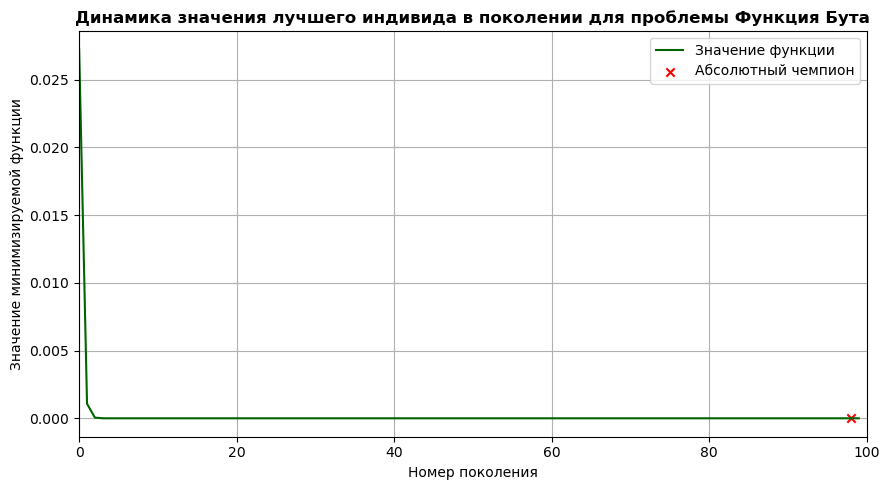

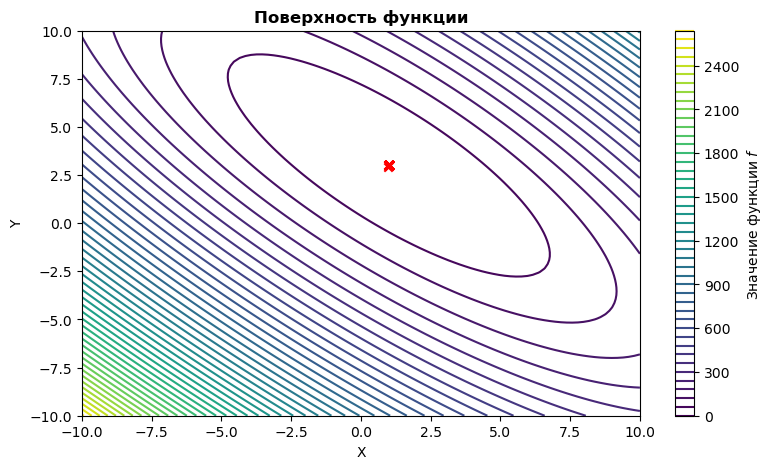

In [12]:
prob = pg.problem(Booth)

pop_Booth, individuals_list, fitness_list = train(prob, algo)
plot_minimization(Booth, fitness_list, number_evols)
plot_surface(prob, individuals_list)

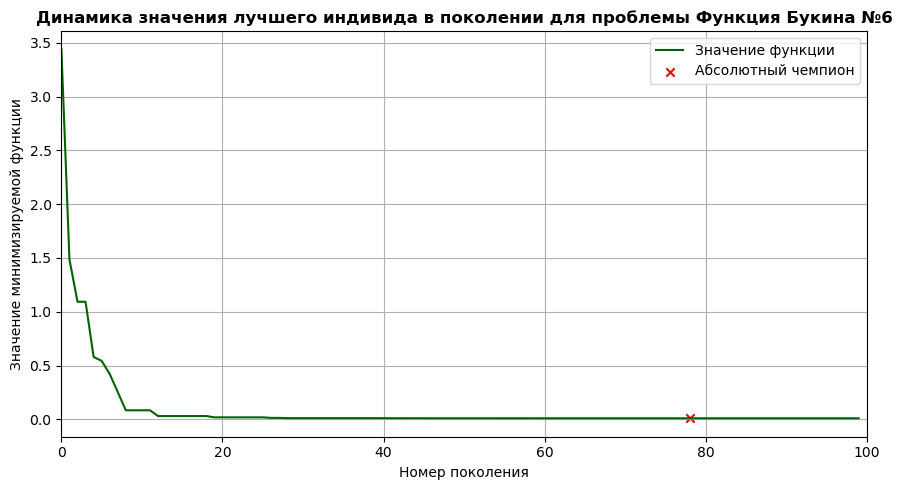

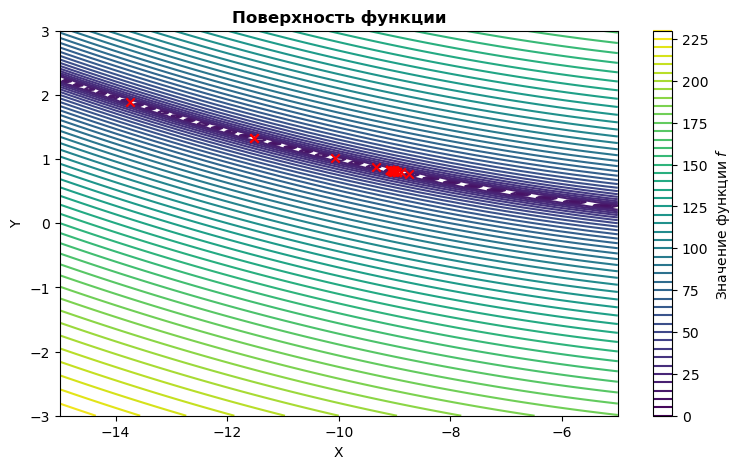

In [13]:
prob = pg.problem(BukinN6)

pop_BukinN6, individuals_list, fitness_list = train(prob, algo)
plot_minimization(BukinN6, fitness_list, number_evols)
plot_surface(BukinN6, individuals_list)

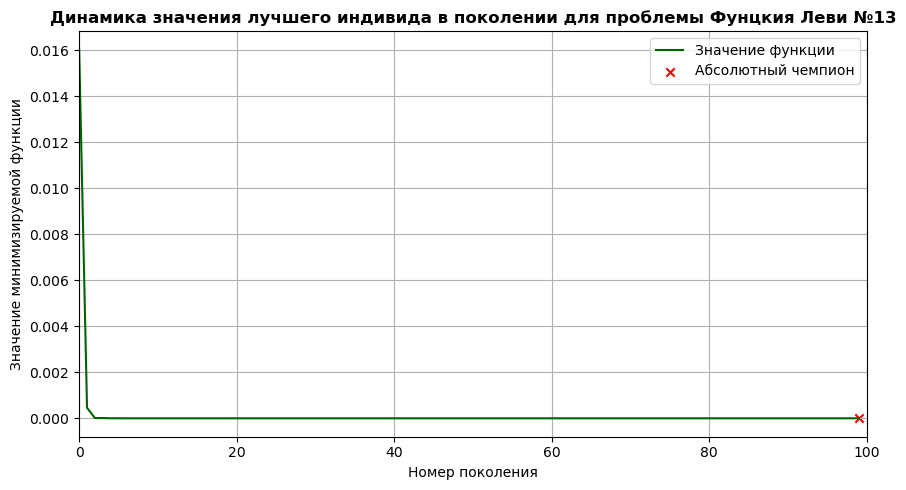

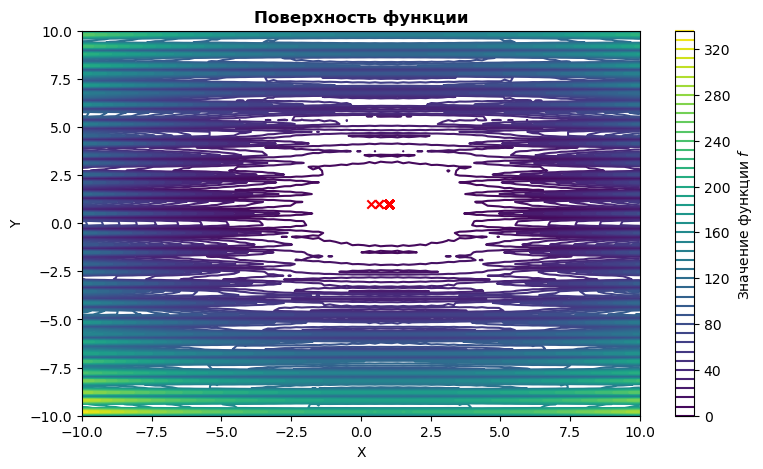

In [14]:
prob = pg.problem(Levi13)

pop_Levi13, individuals_list, fitness_list = train(prob, algo)
plot_minimization(Levi13, fitness_list, number_evols)
plot_surface(Levi13, individuals_list)

## GWO

In [15]:
algo = pg.algorithm(pg.gwo(gen=10))

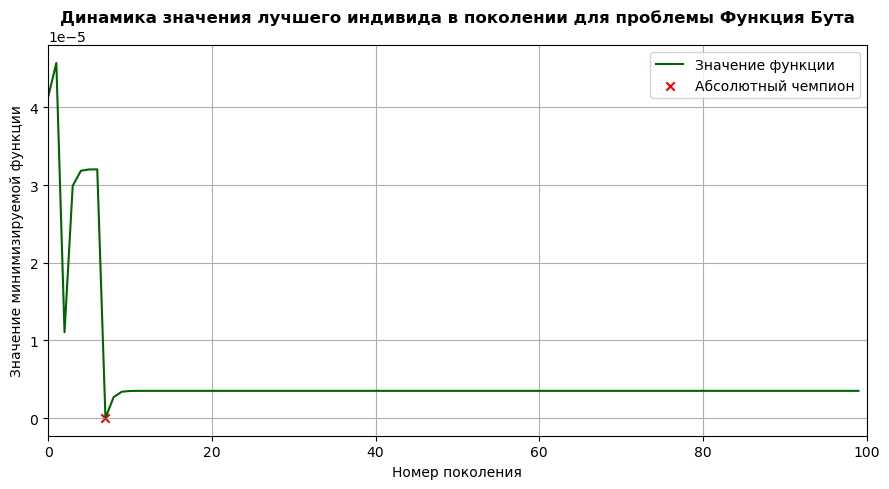

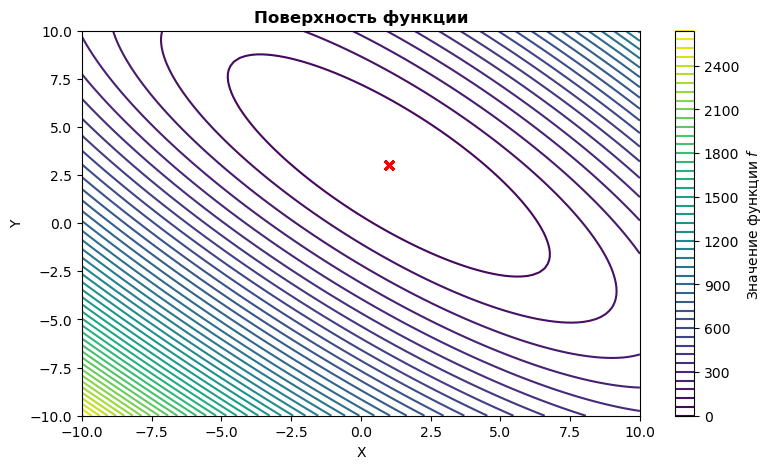

In [16]:
prob = pg.problem(Booth)

pop_Booth, individuals_list, fitness_list = train(prob, algo)
plot_minimization(Booth, fitness_list, number_evols)
plot_surface(prob, individuals_list)

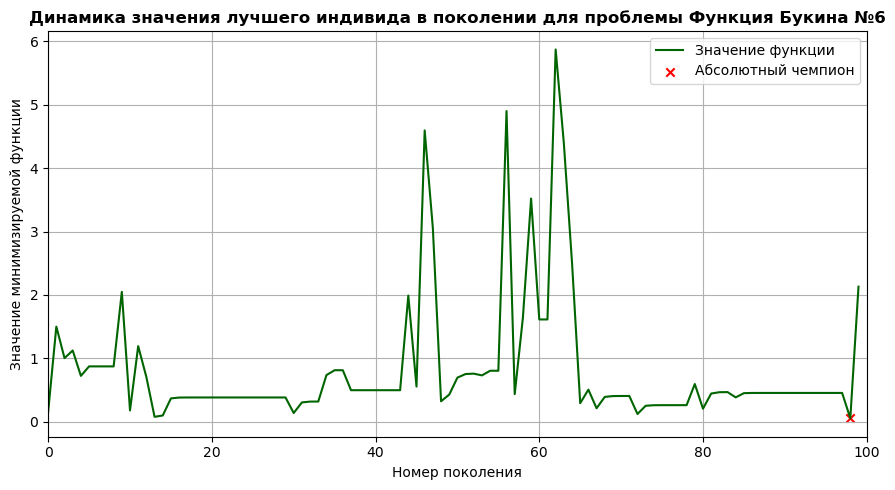

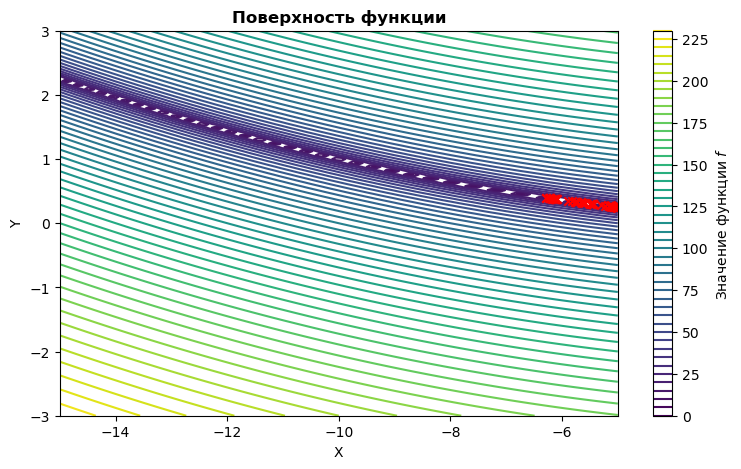

In [17]:
prob = pg.problem(BukinN6)

pop_BukinN6, individuals_list, fitness_list = train(prob, algo)
plot_minimization(BukinN6, fitness_list, number_evols)
plot_surface(BukinN6, individuals_list)

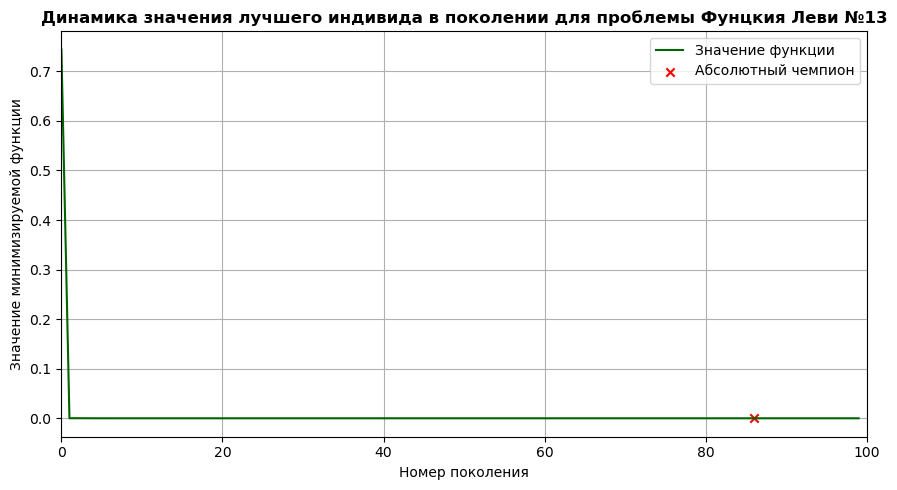

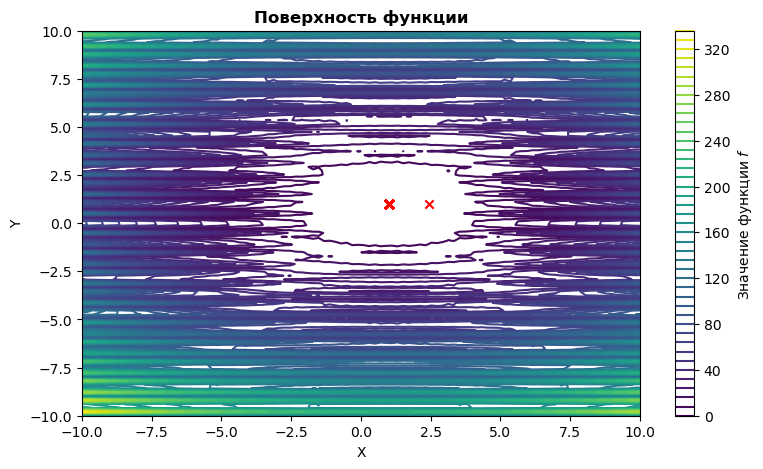

In [18]:
prob = pg.problem(Levi13)

pop_Levi13, individuals_list, fitness_list = train(prob, algo)
plot_minimization(Levi13, fitness_list, number_evols)
plot_surface(Levi13, individuals_list)

## GACO

In [19]:
algo = pg.algorithm(pg.gaco(gen=gen))

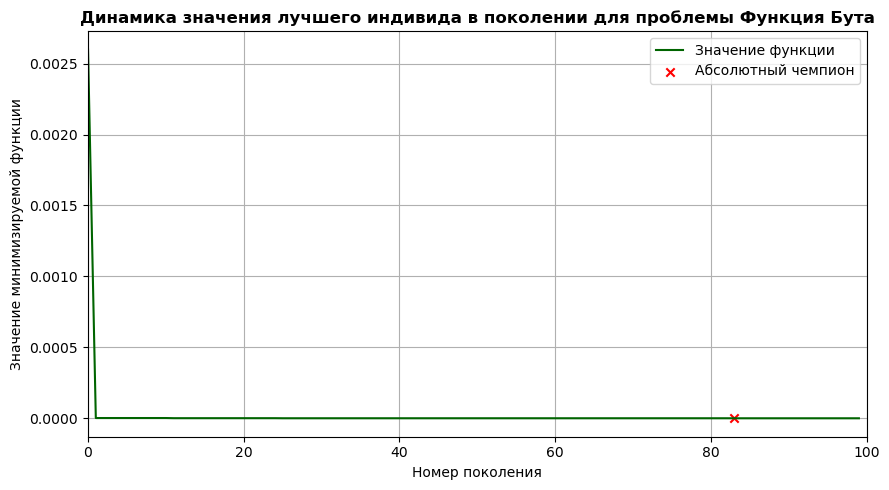

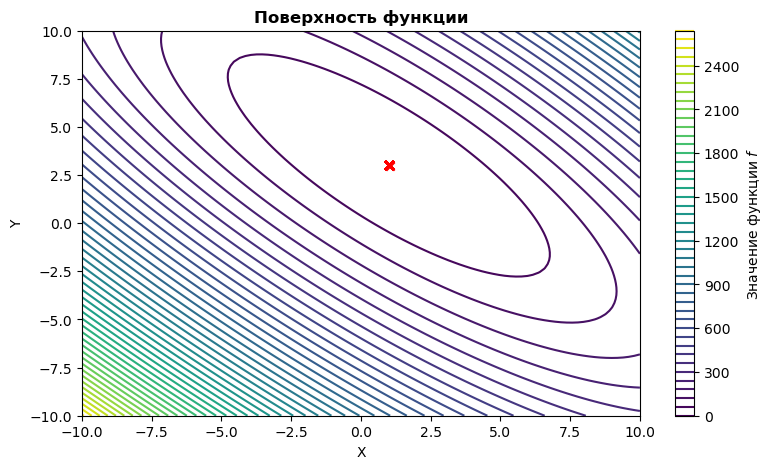

In [20]:
prob = pg.problem(Booth)

pop_Booth, individuals_list, fitness_list = train(prob, algo)
plot_minimization(Booth, fitness_list, number_evols)
plot_surface(prob, individuals_list)

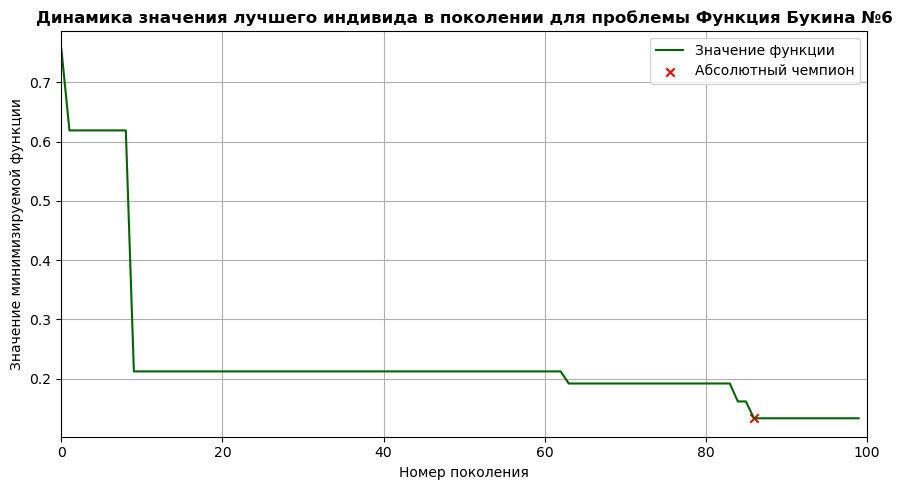

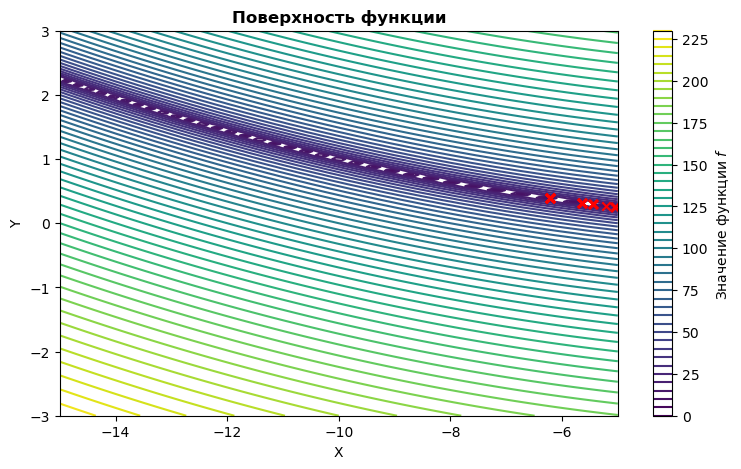

In [21]:
prob = pg.problem(BukinN6)

pop_BukinN6, individuals_list, fitness_list = train(prob, algo)
plot_minimization(BukinN6, fitness_list, number_evols)
plot_surface(BukinN6, individuals_list)

## Тестирование алгоритма на функции Леви №13

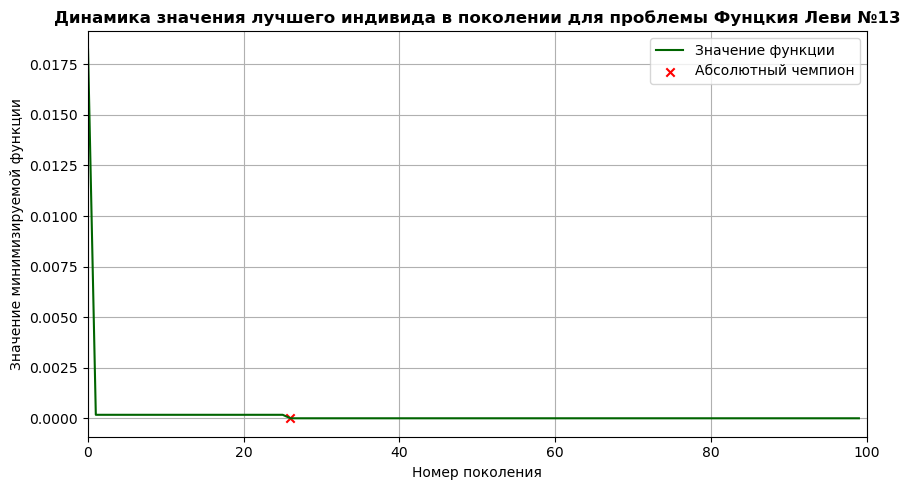

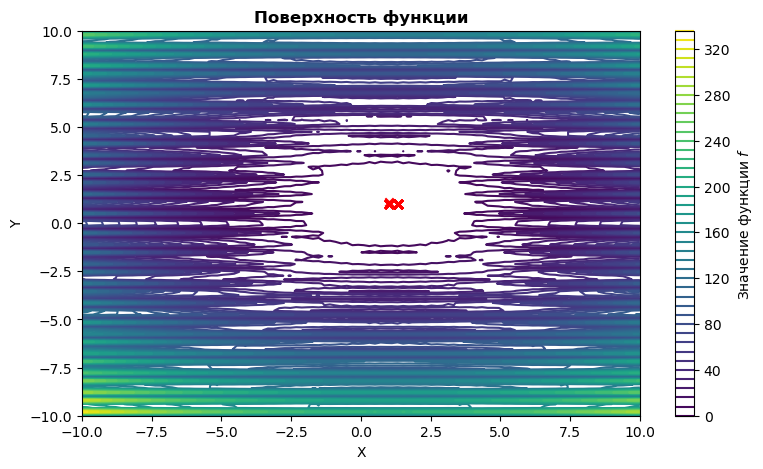

In [22]:
prob = pg.problem(Levi13)

pop_Levi13, individuals_list, fitness_list = train(prob, algo)
plot_minimization(Levi13, fitness_list, number_evols)
plot_surface(Levi13, individuals_list)

# Результат работы алгоритмов

In [23]:
df

,Method,Pop_Size,Num_Geners,Num_Evoluts,Min_Coordinates,Function_Value
0,saDE: Self-adaptive Differential Evolution,100,10,100,"[1.0, 3.0]",[0.0]
1,saDE: Self-adaptive Differential Evolution,100,10,100,"[-9.01184, 0.81213]",[0.00988]
2,saDE: Self-adaptive Differential Evolution,100,10,100,"[1.0, 1.0]",[0.0]
3,GWO: Grey Wolf Optimizer,100,10,100,"[0.99994, 3.00008]",[0.0]
4,GWO: Grey Wolf Optimizer,100,10,100,"[-5.00102, 0.2501]",[0.05668]
5,GWO: Grey Wolf Optimizer,100,10,100,"[1.00005, 0.99965]",[0.0]
6,GACO: Ant Colony Optimization,100,10,100,"[1.0001, 2.99997]",[0.0]
7,GACO: Ant Colony Optimization,100,10,100,"[-5.4426, 0.29622]",[0.13319]
8,GACO: Ant Colony Optimization,100,10,100,"[1.33309, 0.99974]",[1e-05]
